In [1]:
## Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector, RFE
from sklearn.feature_selection import r_regression, f_regression, mutual_info_regression
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor, VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score
from sklearn.feature_selection import SelectKBest, SelectPercentile
from xgboost import XGBRegressor , XGBClassifier

In [2]:
def extract():
    # Load the CSV files
    csv0 = pd.read_csv("ids_0.csv")
    csv1 = pd.read_csv("ids_1.csv")
    csv2 = pd.read_csv("ids_2.csv")
    combined = pd.concat([ csv0 , csv1 , csv2], ignore_index=True)

    # Load the JSON files
    json3 = pd.read_json("ids_3.json", lines=True)
    json4 = pd.read_json("ids_4.json", lines=True)
    json7 = pd.read_json("ids_7.json", lines=True)
    json9 = pd.read_json("ids_9.json", lines=True)
    json10 = pd.read_json("ids_10.json", lines=True)
    combined = pd.concat([combined , json3 , json4 , json7 , json9 , json10], ignore_index=True)

    # Load the Parquet files
    parquet5 = pd.read_parquet("ids_5.parquet")
    parquet6 = pd.read_parquet("ids_6.parquet")
    parquet8 = pd.read_parquet("ids_8.parquet")
    parquet11 = pd.read_parquet("ids_11.parquet")
    combined = pd.concat([combined , parquet5 , parquet6 , parquet8 , parquet11], ignore_index=True)
    
    return combined

data = extract()

In [3]:
#Transform section
data = data.dropna()

#Load section
data.to_csv('dataSet.csv', index=False)

In [4]:
#Reading data section (Load to dataframe)
data = pd.read_csv('dataSet.csv')


In [5]:
#Drop duplicate values
data = data.drop_duplicates()

#Identify shape of the dataset.
print("Dataset shape: " , data.shape)

#Cleanup Column names / remove duplicate columns
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(" " , "_")
data.columns = data.columns.str.replace(".1" , "")
data = data.loc[:,~data.columns.duplicated()].copy()

Dataset shape:  (45556, 79)


In [6]:
#Identify if dataset has missing data.
print("No. of missing data in dataset: " + str(data.isna().sum().sum()))

No. of missing data in dataset: 0


In [7]:
# Remove the Heartbleed rows
data = data[data.Label != 'Heartbleed']

#Create attack DF (y axis)
attack = data[['Label']]

#Delete 'Label' from original dataset
data.drop('Label',axis=1, inplace=True)

In [8]:
#Performing univariate analysis.
#Drop features with variance less than .05 (removing 0 variance)
data = data.loc[:, data.var(axis=0) >= 0.05]

In [9]:
#Encoding data
attack['Label'] = attack['Label'].replace('BENIGN', 0, regex=True)
attack['Label'] = attack['Label'].replace('DoS Hulk', 1, regex=True)
attack['Label'] = attack['Label'].replace('DoS GoldenEye', 1, regex=True)
attack['Label'] = attack['Label'].replace('DoS Slowhttptest', 1, regex=True)

In [10]:
#split the data
features = data.to_numpy()
label = attack.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.25, random_state=6969)

y_train = y_train.flatten()
y_test = y_test.flatten()

In [11]:
#standardize the data
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.fit(X_test)

In [12]:
#Describe the data to ensure correct standardization
print(pd.DataFrame(X_train_standard).describe())

                 0             1             2             3             4   \
count  3.415800e+04  3.415800e+04  3.415800e+04  3.415800e+04  3.415800e+04   
mean  -3.952313e-18  4.014718e-17 -3.432272e-17 -1.102487e-17 -4.888388e-18   
std    1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00   
min   -1.550852e-01 -1.167838e+00 -5.313520e-01 -3.276095e-01 -1.942267e-01   
25%   -1.436581e-01 -9.592760e-01 -2.278738e-01 -1.872283e-01 -1.625095e-01   
50%   -1.436581e-01  2.993378e-01 -2.555491e-02  2.334343e-02 -4.004590e-02   
75%   -1.436581e-01  1.118189e+00  1.767639e-01  9.353402e-02 -1.581748e-02   
max    9.188888e+00  1.622811e+00  1.234901e+02  1.159782e+02  1.608300e+02   

                 5             6             7             8             9   \
count  3.415800e+04  3.415800e+04  3.415800e+04  3.415800e+04  3.415800e+04   
mean   5.408429e-18 -6.926949e-17  9.620763e-18  8.562999e-16  9.227820e-15   
std    1.000015e+00  1.000015e+00  1.000015e+00  1.

In [13]:
#Feature selection
xgbC = XGBClassifier()
xgbC.fit(X_train_standard,y_train)
selection = SelectFromModel(xgbC,threshold=.01, prefit=True)
X_train_selected = selection.transform(X_train)
X_test_selected = selection.transform(X_test)

In [29]:
#Processed Data Loading / upload cleaned data
pd.DataFrame(X_train_selected).to_csv('CleanTrain.csv', index=False)
pd.DataFrame(X_test_selected).to_csv('CleanTest.csv', index=False)


In [15]:
#XGBC MODEL
xgbC.fit(X_train_selected , y_train)
X_train_selected_pred = xgbC.predict(X_train_selected)
X_test_selected_pred = xgbC.predict(X_test_selected)

train_acc_perc = accuracy_score(y_train, X_train_selected_pred)
train_f1score_perc = f1_score(y_train, X_train_selected_pred)
train_precision_perc = precision_score(y_train, X_train_selected_pred)
train_recall_perc = recall_score(y_train, X_train_selected_pred)

print('Train XGBC Model')
print('Accuracy: {:.3f}'.format(train_acc_perc))
print('Precision: {:.3f}'.format(train_precision_perc))
print('Recall: {:.3f}'.format(train_recall_perc))
print('F1-score: {:.3f}'.format(train_f1score_perc))

test_acc_perc = accuracy_score(y_test, X_test_selected_pred)
test_f1score_perc = f1_score(y_test, X_test_selected_pred)
test_precision_perc = precision_score(y_test, X_test_selected_pred)
test_recall_perc = recall_score(y_test, X_test_selected_pred)

print('\nTest XGBC Model')
print('Accuracy: {:.3f}'.format(test_acc_perc))
print('Precision: {:.3f}'.format(test_precision_perc))
print('Recall: {:.3f}'.format(test_recall_perc))
print('F1-score: {:.3f}'.format(test_f1score_perc))

Train XGBC Model
Accuracy: 0.995
Precision: 0.995
Recall: 0.999
F1-score: 0.997

Test XGBC Model
Accuracy: 0.995
Precision: 0.995
Recall: 0.999
F1-score: 0.997


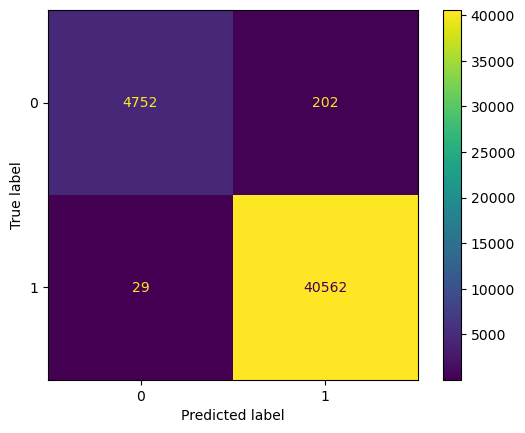

In [16]:
ConfusionMatrixDisplay.from_estimator(xgbC, np.concatenate((X_train_selected, X_test_selected), axis=0), np.concatenate((y_train, y_test)))

In [17]:
#PERCEPTRON MODEL
perceptron = Perceptron(eta0=0.001, random_state=1)
perceptron.fit(X_train_selected,y_train)
X_train_selected_pred = perceptron.predict(X_train_selected)
X_test_selected_pred = perceptron.predict(X_test_selected)

train_acc_perc = accuracy_score(y_train, X_train_selected_pred)
train_f1score_perc = f1_score(y_train, X_train_selected_pred)
train_precision_perc = precision_score(y_train, X_train_selected_pred)
train_recall_perc = recall_score(y_train, X_train_selected_pred)

print('Train Perceptron Model')
print('Accuracy: {:.3f}'.format(train_acc_perc))
print('Precision: {:.3f}'.format(train_precision_perc))
print('Recall: {:.3f}'.format(train_recall_perc))
print('F1-score: {:.3f}'.format(train_f1score_perc))

test_acc_perc = accuracy_score(y_test, X_test_selected_pred)
test_f1score_perc = f1_score(y_test, X_test_selected_pred)
test_precision_perc = precision_score(y_test, X_test_selected_pred)
test_recall_perc = recall_score(y_test, X_test_selected_pred)

print('\nTest Perceptron Model')
print('Accuracy: {:.3f}'.format(test_acc_perc))
print('Precision: {:.3f}'.format(test_precision_perc))
print('Recall: {:.3f}'.format(test_recall_perc))
print('F1-score: {:.3f}'.format(test_f1score_perc))

Train Perceptron Model
Accuracy: 0.910
Precision: 0.931
Recall: 0.971
F1-score: 0.951

Test Perceptron Model
Accuracy: 0.911
Precision: 0.929
Recall: 0.974
F1-score: 0.951


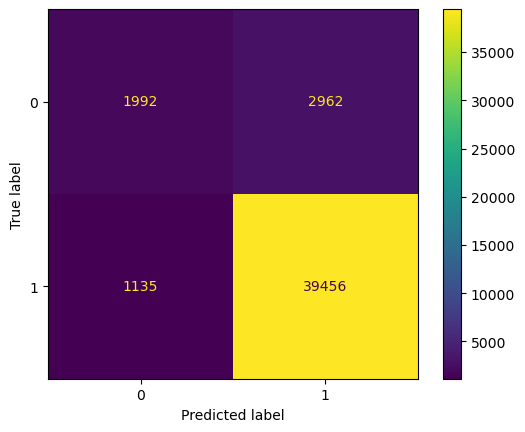

In [18]:
ConfusionMatrixDisplay.from_estimator(perceptron, np.concatenate((X_train_selected, X_test_selected), axis=0), np.concatenate((y_train, y_test)))

In [19]:
#ADABOOST MODEL
adaboost_perc = AdaBoostClassifier(estimator=Perceptron(eta0=0.001, random_state=1), n_estimators=100, learning_rate=0.001, random_state=1, algorithm='SAMME')
adaboost_perc.fit(X_train_selected,y_train)
X_train_selected_pred = adaboost_perc.predict(X_train_selected)
X_test_selected_pred = adaboost_perc.predict(X_test_selected)

train_acc_perc = accuracy_score(y_train, X_train_selected_pred)
train_f1score_perc = f1_score(y_train, X_train_selected_pred)
train_precision_perc = precision_score(y_train, X_train_selected_pred)
train_recall_perc = recall_score(y_train, X_train_selected_pred)

print('Train ADABoost Model')
print('Accuracy: {:.3f}'.format(train_acc_perc))
print('Precision: {:.3f}'.format(train_precision_perc))
print('Recall: {:.3f}'.format(train_recall_perc))
print('F1-score: {:.3f}'.format(train_f1score_perc))

test_acc_perc = accuracy_score(y_test, X_test_selected_pred)
test_f1score_perc = f1_score(y_test, X_test_selected_pred)
test_precision_perc = precision_score(y_test, X_test_selected_pred)
test_recall_perc = recall_score(y_test, X_test_selected_pred)

print('\nTest ADABoost Model')
print('Accuracy: {:.3f}'.format(test_acc_perc))
print('Precision: {:.3f}'.format(test_precision_perc))
print('Recall: {:.3f}'.format(test_recall_perc))
print('F1-score: {:.3f}'.format(test_f1score_perc))

Train ADABoost Model
Accuracy: 0.928
Precision: 0.974
Recall: 0.945
F1-score: 0.959

Test ADABoost Model
Accuracy: 0.928
Precision: 0.972
Recall: 0.946
F1-score: 0.959


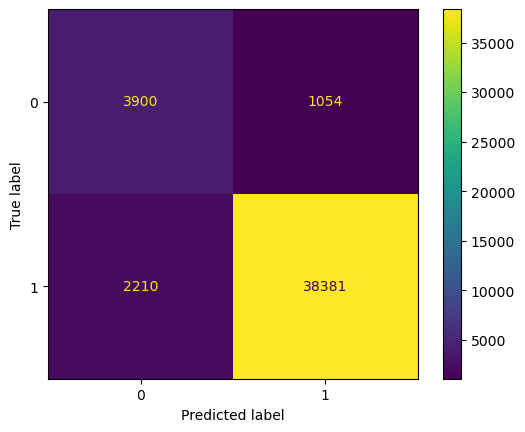

In [20]:
ConfusionMatrixDisplay.from_estimator(adaboost_perc, np.concatenate((X_train_selected, X_test_selected), axis=0), np.concatenate((y_train, y_test)))

In [21]:
#LOGISTIC REGRESSION MODEL
lr = LogisticRegression()
lr.fit(X_train_selected,y_train)
X_train_selected_pred = lr.predict(X_train_selected)
X_test_selected_pred = lr.predict(X_test_selected)

train_acc_perc = accuracy_score(y_train, X_train_selected_pred)
train_f1score_perc = f1_score(y_train, X_train_selected_pred)
train_precision_perc = precision_score(y_train, X_train_selected_pred)
train_recall_perc = recall_score(y_train, X_train_selected_pred)

print('Train Logistic Regression Model')
print('Accuracy: {:.3f}'.format(train_acc_perc))
print('Precision: {:.3f}'.format(train_precision_perc))
print('Recall: {:.3f}'.format(train_recall_perc))
print('F1-score: {:.3f}'.format(train_f1score_perc))

test_acc_perc = accuracy_score(y_test, X_test_selected_pred)
test_f1score_perc = f1_score(y_test, X_test_selected_pred)
test_precision_perc = precision_score(y_test, X_test_selected_pred)
test_recall_perc = recall_score(y_test, X_test_selected_pred)

print('\nTest Logistic Regression Model')
print('Accuracy: {:.3f}'.format(test_acc_perc))
print('Precision: {:.3f}'.format(test_precision_perc))
print('Recall: {:.3f}'.format(test_recall_perc))
print('F1-score: {:.3f}'.format(test_f1score_perc))


Train Logistic Regression Model
Accuracy: 0.913
Precision: 0.938
Recall: 0.966
F1-score: 0.952

Test Logistic Regression Model
Accuracy: 0.913
Precision: 0.936
Recall: 0.969
F1-score: 0.952


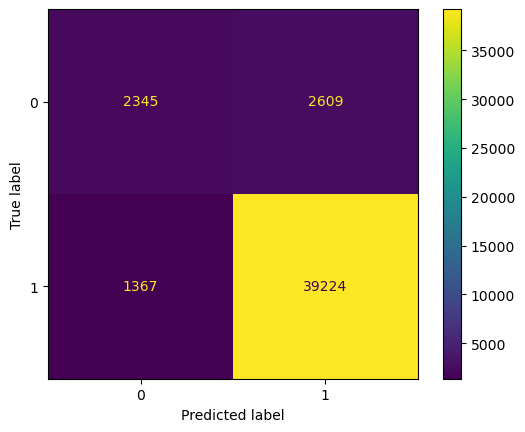

In [22]:
ConfusionMatrixDisplay.from_estimator(lr, np.concatenate((X_train_selected, X_test_selected), axis=0), np.concatenate((y_train, y_test)))

In [23]:
#MAJORITYVOTING MODEL
hard_majorityvote = VotingClassifier(estimators=[('perceptron', perceptron),('adaboost_perc', adaboost_perc),('logistic regression', lr)],voting='hard')
hard_majorityvote.fit(X_train_selected,y_train)
X_train_selected_pred = hard_majorityvote.predict(X_train_selected)
X_test_selected_pred = hard_majorityvote.predict(X_test_selected)

train_acc_perc = accuracy_score(y_train, X_train_selected_pred)
train_f1score_perc = f1_score(y_train, X_train_selected_pred)
train_precision_perc = precision_score(y_train, X_train_selected_pred)
train_recall_perc = recall_score(y_train, X_train_selected_pred)

print('Train Mayority Voting Model')
print('Accuracy: {:.3f}'.format(train_acc_perc))
print('Precision: {:.3f}'.format(train_precision_perc))
print('Recall: {:.3f}'.format(train_recall_perc))
print('F1-score: {:.3f}'.format(train_f1score_perc))

test_acc_perc = accuracy_score(y_test, X_test_selected_pred)
test_f1score_perc = f1_score(y_test, X_test_selected_pred)
test_precision_perc = precision_score(y_test, X_test_selected_pred)
test_recall_perc = recall_score(y_test, X_test_selected_pred)

print('\nTest Mayority Voting Model')
print('Accuracy: {:.3f}'.format(test_acc_perc))
print('Precision: {:.3f}'.format(test_precision_perc))
print('Recall: {:.3f}'.format(test_recall_perc))
print('F1-score: {:.3f}'.format(test_f1score_perc))

Train Mayority Voting Model
Accuracy: 0.916
Precision: 0.937
Recall: 0.971
F1-score: 0.954

Test Mayority Voting Model
Accuracy: 0.916
Precision: 0.934
Recall: 0.974
F1-score: 0.954


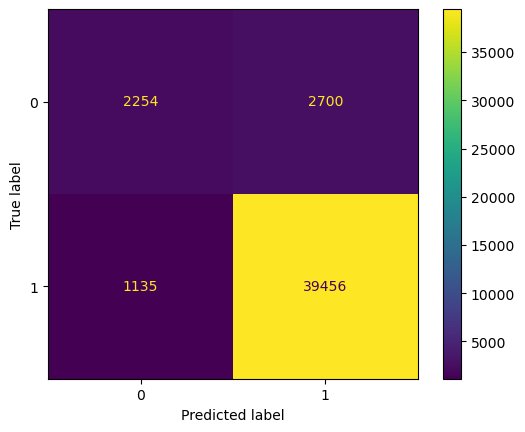

In [24]:
ConfusionMatrixDisplay.from_estimator(hard_majorityvote, np.concatenate((X_train_selected, X_test_selected), axis=0), np.concatenate((y_train, y_test)))